# ECG 5000


### Data Set Information:

The New York Heart Association (NYHA) Classification provides a simple way of classifying the extent of heart failure. It classifies patients in one of four categories based on their limitations during physical activity; the limitations/symptoms are in regards to normal breathing and varying degrees in shortness of breath and or angina pain.

#### Labels description:

- 1: Class 1: No limitation of physical activity. Ordinary physical activity e.g. shortnes of breath when walking, climbing the stairs etc.

- 2: Class 2: Slight limitation of physical activity. Mild symptoms (mild shortness of breath and/or angina) and slight limitation during ordinary activity.

- 3: Class 3: Marked limitation of physical activity. Symptoms noticeable during less-than-ordinary activity.

- 4: Class 4: Severe limitation of physical activity. Symptoms present even at rest. If any physical activity is undertaken, discomfort is increased.

- 5: Class 5: No NYHA class was provided.

### Loading the dataset

The dataset is available in the file `ECG5000_TRAIN.arff` and `ECG5000_TEST.arff`. We will use the `arff` module from the `liac-arff` package to load the dataset.

In [49]:
from scipy.io import arff
import pandas as pd
import numpy as np
# read the data from the arff file
def read_arff_data(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
    return df

In [50]:
# read the data
data = read_arff_data('data/ECG5000_TRAIN.arff')

# read the test data
test_data = read_arff_data('data/ECG5000_TEST.arff')

# print the data
print(data.shape)

(500, 141)


#### Plotting the ECG signal of different classes

We will plot the ECG signal of different classes to see if there is any difference in the ECG signal of different classes. we will pick 5 samples from each class and plot them with different colors. in the plot, x-axis will be the time and y-axis will be the amplitude of the ECG signal.

In [51]:
# plot the graphs of normal and abnormal ECG to visualise the trends



def select_samples(df, n_samples):
    label_column = df.columns[-1]
    return df.groupby(label_column).apply(lambda x: x.sample(n=n_samples))

# select 5 samples from each class
sample_df = select_samples(data, 2)
print(sample_df.shape)

(10, 141)


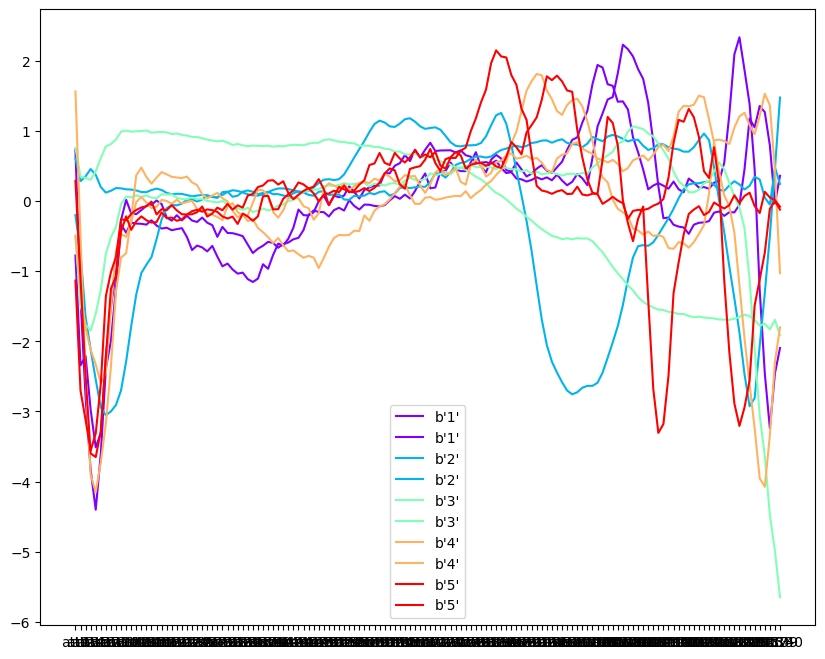

In [52]:
import matplotlib.pyplot as plt

def plot_samples(df):
    label_column = df.columns[-1]
    labels = df[label_column].unique()

    # Create a color map
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    color_map = dict(zip(labels, colors))

    plt.figure(figsize=(10, 8))

    for label in labels:
        subset = df[df[label_column] == label]
        for i, row in subset.iterrows():
            plt.plot(row[:-1], color=color_map[label], label=label)

    plt.legend()
    plt.show()


plot_samples(sample_df)

### Preprocessing the data


Seperate the data into features and labels. The features are the ECG signal and the labels are the classes of the ECG signal. We will also normalize the data using the `MinMaxScaler` from the `sklearn` package.

In [53]:
# function to separate the data into features and labels
def separate_features_labels(data):
    # separate the data into features and labels
    features = data.iloc[:, :-1]
    labels = data.iloc[:, -1]
    return features, labels

data_features, data_labels = separate_features_labels(data)
test_data_features, test_data_labels = separate_features_labels(test_data)

# print the features and labels
print(data_features.shape)
print(data_labels.shape)
# print the test data
print(test_data_features.shape)
print(test_data_labels.shape)

(500, 140)
(500,)
(4500, 140)
(4500,)


Now, we can check fo missing values and the data types of the columns.

In [54]:
data_features.isna().sum().sum()

0

Now, we normalize the data using the `MinMaxScaler` from the `sklearn` package.

In [55]:
from sklearn.preprocessing import MinMaxScaler

def scale_features(features):
    # create a scaler object
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # fit and transform the data
    scaled_features = scaler.fit_transform(features)
    return scaled_features

# scale the features
scaled_data_features = scale_features(data_features)
scaled_test_data_features = scale_features(test_data_features)

Now, we filter the data to eleminate the noise and extract the important features. We will use three algorithms:

- Median filter
- Low pass filter
- Wavelet transform

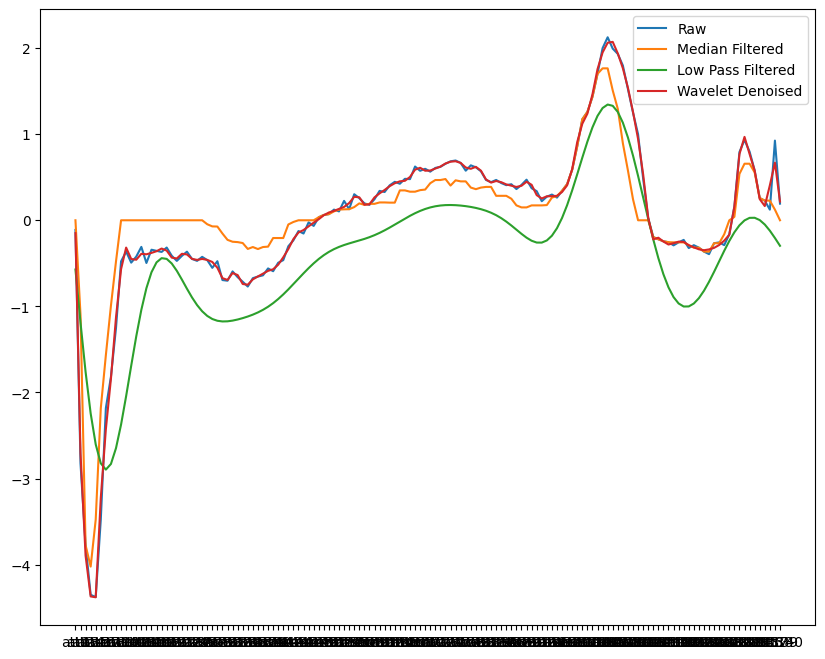

In [58]:
# filtering the raw signal
from scipy.signal import butter, medfilt, filtfilt
import pywt

def median_filter(data, kernel_size=3):
    return medfilt(data, kernel_size)

def low_pass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def wavelet_denoising(data):
    coeffs = pywt.wavedec(data, 'db4', level=1)
    threshold = np.std(coeffs[-1]) * np.sqrt(2*np.log(len(data)))
    coeffs[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeffs[1:])
    return pywt.waverec(coeffs, 'db4')
    
    
ecg_median_filtered = median_filter(data_features)
ecg_low_pass_filtered = low_pass_filter(data_features, 0.05, 40, 720)
ecg_wavelet_denoised = wavelet_denoising(data_features)

# plot the raw, median filtered, low pass filtered and wavelet denoised signals of a normal ECG
plt.figure(figsize=(10, 8))
plt.plot(data_features.iloc[0, :])
plt.plot(ecg_median_filtered[0])
plt.plot(ecg_low_pass_filtered[0])
plt.plot(ecg_wavelet_denoised[0])
plt.legend(['Raw', 'Median Filtered', 'Low Pass Filtered', 'Wavelet Denoised'])
plt.show()